<a href="https://colab.research.google.com/github/srezazad/Succesive-Projection-Algirithm-for-Matrix-Recovery-/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Succesive Projection Algorithm 

The seperable matrix $H$ can be written as 
\begin{equation}
M = WH = W\cdot [I_r, H'], \text{ where } W\in \mathbb{R}^{m\times r},
\end{equation}
has rank $r$, $H\in \mathbb{R}_+^{r\times n}$, and the sum of each column of $H$ is at most 1. Note that the assumption on the matrix $H$ is made without loss of generality. The following code implements the succesive projection algorithm (SPA). 


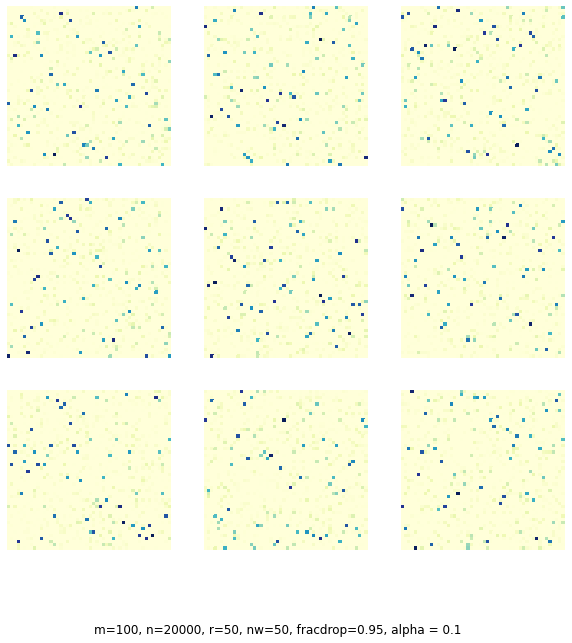

In [1]:
import numpy as np 
import cupy as cp 
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt
import cProfile


m=100       # % m = number of rows in M = number of features 
n=20000      # % n = number of columns in M = number of documents
r=50    # % r = rank, number of columns in W and number of rows in H
nw=50    # % nw: each topic (column of W) will have nw nonzero entries chosen at random.
fracdrop=.95  # % fracdrop: fraction between 0 and 1 of number of entries to drop
alpha0=.1 # % alpha0: parameter for Dirichlet distribution in generation of H.


def generate_W_gpu(m,r):
  
  W_gpu = cp.zeros((m,r))
  normsW_gpu = cp.zeros((r,))
  
  for j in cp.arange(0,r):

    wcol_data = cp.random.rand(nw,1)
    wcol_data = wcol_data / cp.sum(wcol_data)  
    pr = cp.random.permutation(cp.arange(m))
    nws = pr[1:nw+1]
    W_gpu[nws, j] = wcol_data.reshape((nw,)) 
    normsW_gpu[j] = cp.linalg.norm(wcol_data) 
  return W_gpu, normsW_gpu 


def generate_H_gpu(r,n):

  H_gpu = cp.random.gamma(shape=alpha0, size=[int(r),int(n)])
  H_gpu = H_gpu / cp.sum(H_gpu, axis=0)
  # maxsH_gpu = cp.ndarray.max(H_gpu, axis=1)
  return H_gpu 

def generate_M_gpu(W_gpu, H_gpu):
   
    M_gpu = cp.dot(W_gpu, H_gpu)
    K_gpu = cp.random.choice([0,1], size=[int(m),int(n)], p = [fracdrop, 1-fracdrop])
    M_gpu = cp.multiply(M_gpu,K_gpu)
    return M_gpu 


def test_spa_missing_entries_gpu(m,n,r,nw,fracdrop,alpha0,H):
    
    W_gpu = generate_W_gpu(m,r)[0]
    H_gpu = generate_H_gpu(r,n)
    M_gpu = generate_M_gpu(W_gpu, H_gpu) 
    mxpos = cp.zeros((r,1))
    V_gpu = cp.zeros((m,r))

    for i in cp.arange(r):

        mxpos_val = int(np.argmax(cp.sum(cp.multiply(M_gpu,M_gpu),0)))
        mxpos[i] = mxpos_val
        v = M_gpu[:,mxpos_val]
        V_gpu[:,i] = v
        v = M_gpu[:,mxpos_val].reshape(-1,1)
        v = v / cp.linalg.norm(v)
        M_gpu = cp.subtract(M_gpu, cp.matmul(v, cp.matmul(cp.transpose(v), M_gpu)))
    mxpos = [int(i) for [i] in mxpos.tolist()]
    H = H_gpu[:, mxpos]

    return cp.asnumpy(H), cp.asnumpy(V_gpu)

n_tries = 9   
fig = plt.figure(figsize=(10,10))

for k in np.arange(n_tries):
  H = test_spa_missing_entries_gpu(m,n,r,nw,fracdrop,alpha0, H=cp.zeros((3,3)))[0]
  plt.subplot(f'33{k}')
  ax = sns.heatmap(H, cmap="YlGnBu", cbar=False)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.tick_params(left=False, bottom=False) ## other options are right and top

txt=f"m={m}, n={n}, r={r}, nw={nw}, fracdrop={fracdrop}, alpha = {alpha0}"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Dirichlet Distribution 

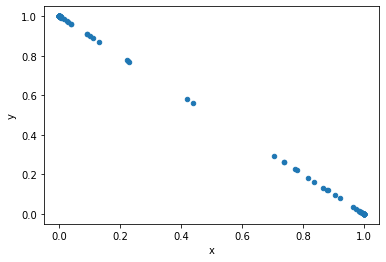

In [ ]:
import cupy as cp 
import pandas as pd 

r=2
def dirichlet(n=100, alpha=0.1):

  H_gpu = cp.random.gamma(shape=alpha, size=[int(r),int(n)])
  H_gpu = H_gpu / cp.sum(H_gpu, axis=0)
  H = cp.asnumpy(H_gpu)
  return pd.DataFrame(H.T, columns=['x','y'])

H_d = dirichlet()
H_d.plot(x ='x', y='y', kind = 'scatter')
plt.show()

# Confusion matrix of columns of M

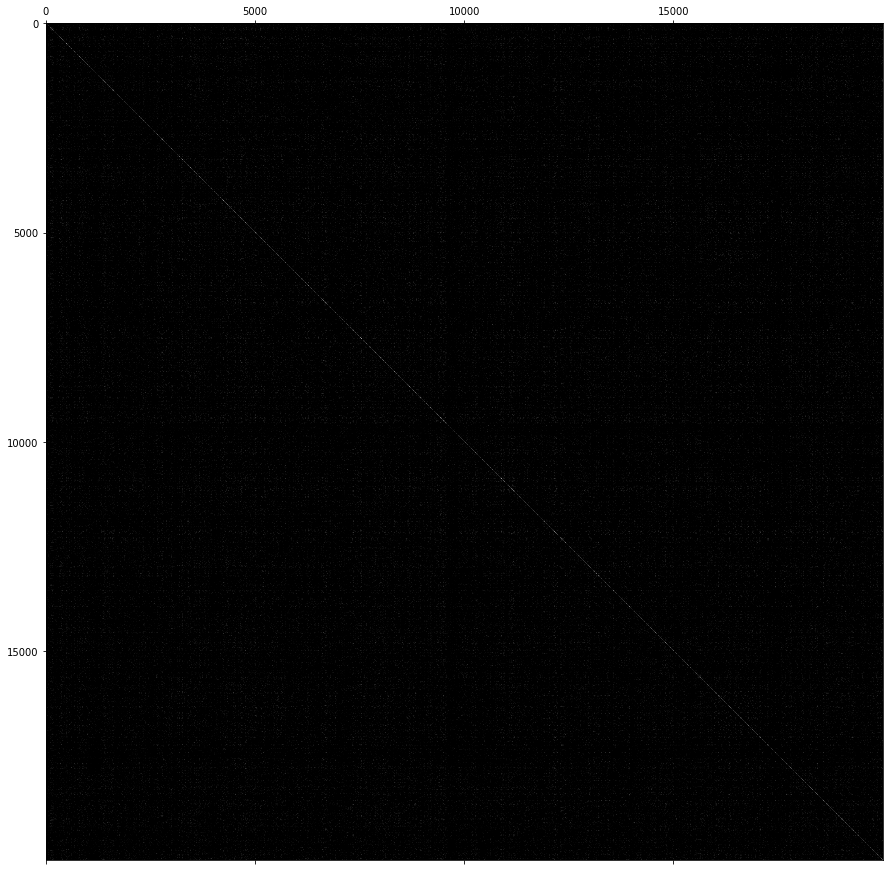

In [2]:
W_gpu   = generate_W_gpu(m,r)[0]
H_gpu   = generate_H_gpu(r,n)
M_gpu   = generate_M_gpu(W_gpu, H_gpu) 
MTM_gpu = cp.matmul(cp.transpose(M_gpu), M_gpu) 
MTM_cpu = MTM_gpu.get()
plt.figure(figsize=(15,15))
plt.matshow(MTM_cpu, cmap=plt.cm.gray, fignum=1)
plt.show()

# Concentration for norm of W's columns 

In [23]:
nws = np.arange(50, 1000, 10)
means = []
stds = []
for nw in nws:
  m = 2*nw 
  normsW_gpu = generate_W_gpu(m,r)[1].get()
  means.append(np.mean(normsW_gpu))
  stds.append(np.std(normsW_gpu))

means_down = np.subtract(means,stds) 
means_up = np.add(means,stds) 

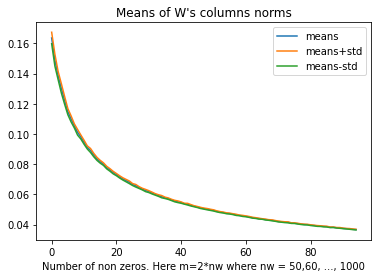

In [44]:
x = range(len(means))
fig, ax = plt.subplots()
ax.plot(x, means, label='means')
ax.plot(x,means_up, label='means+std')
ax.plot(x, means_down, label='means-std')
ax.legend()
ax.set_xlabel('Number of non zeros. Here m=2*nw where nw = 50,60, ..., 1000')
ax.set_title("Means of W's columns norms")
plt.show()